In [1]:
import numpy as np
import torch

# Введение в Pytorch

## Pytorch и Numpy

Основные методы обучения нейронных сетей являются методами оптимизации первого порядка. Они присутствуют, например, в пакете `scipy.optimize`, но либо считают градиенты численно, либо требуют внешних функций, предоставляющих им градиенты в требуемой точке. Написание таких функций вручную для каждой нейронной сети - задача решаемая, но достаточно бессмысленная, т.к. производные, даже аналитически, достаточно легко может считать и машина.

Концепция библиотеки pytorch - расширить функционал numpy, добавив туда возможность автоматического расчёта градиентов произвольных функций и их композиций, стараясь максимально сохранить привычную семантику.

Совсем без различий, правда, не обошлось:

`x.reshape((1,2,8))` -> `x.view(1,2,8)`

`x.sum(axis=-1)` -> `x.sum(dim=-1)`

`x.astype(np.float32)` -> `x.type(torch.float32)` или `x.float()`

Более подробный список различий и полезных команд приведён в конце ноутбука.

In [2]:
x = np.array([1., 2., 3.])
y = torch.tensor([1., 2., 3.])

x, y

(array([1., 2., 3.]), tensor([1., 2., 3.]))

Тензоры numpy можно переводить в pytorch без копирования.

In [3]:
y = torch.from_numpy(x)
y

tensor([1., 2., 3.], dtype=torch.float64)

Однако, из-за работы с gpu, в pytorch часто предпочитают использовать 32-битные данные, а в numpy типы по умолчанию занимают 64 бита. Аналогичная ситуация и с целочисленными тензорами.

In [4]:
torch.from_numpy(x).dtype, torch.from_numpy(x.astype(np.float32)).dtype, torch.from_numpy(x).float().dtype

(torch.float64, torch.float32, torch.float32)

Также существует обратная операция.

In [5]:
z = y.numpy()
z

array([1., 2., 3.])

Заметим, что теперь все 3 массива x, y, z на самом деле указывают на одну и ту же область памяти:

In [6]:
y[0] = -1
x, y, z

(array([-1.,  2.,  3.]),
 tensor([-1.,  2.,  3.], dtype=torch.float64),
 array([-1.,  2.,  3.]))

In [7]:
np.shares_memory(x, z)

True

# Autograd

По умолчанию, тензоры, создаваемые в pytorch, не будут требовать, чтобы для них посчитали градиент. Для этого надо добавить дополнительный аргумент `requires_grad=True`, либо вызвав метод `.requires_grad_()`.

In [8]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.])
y.requires_grad_()

tensor([1., 2., 3.], requires_grad=True)

Производя операции с переменными, по которым нужно считать градиенты, мы конструируем граф вычислений:

In [9]:
z = 3 * x**3 - y**2
z.requires_grad

True

В каждой переменной есть информация о том, как именно она была получена при проходе вперёд. Исходя из этой информации у тензоров в графе вычислений хранятся функции, которые должны быть вызваны на обратном проходе для расчёта градиента.

In [10]:
z.grad_fn

Считать для каждого тензора якобиан целиком - сильно неоптимально. Вместо этого на всех промежуточных этапах autograd считает только произведения якобиан-вектор. В частности из-за этого, конечный тензор в графе всегда должен быть скаляром, что выполняется для всех функций потерь по определению.


Функции из тензора в скаляр !!!

Для примера сделаем из тензора `z` скаляр, сложив все его элементы, и посчитаем градиенты с помощью функции `.backward()`

In [11]:
z.sum().backward()

x.grad, y.grad

(tensor([ 9., 36., 81.]), tensor([-2., -4., -6.]))

Сравним с посчитанным вручную градиентом:

In [12]:
torch.allclose(x.grad, 9 * x**2)

True

Однако, для оптимизации вычислений, градиенты не вычисляются в явном виде для промежуточных вершин графа

In [13]:
z.grad

/var/folders/sw/9x_lhtp905l1hz3g_nlhmz1h0000gp/T/ipykernel_4053/676359431.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:483.)
  z.grad


Если такое всё же нужно, требуется указать это явно с помощью вызова `.retain_grad()`

In [14]:
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.tensor([1., 2., 3.])

z = 3 * x**3 - y**2
z.retain_grad()

z.sum().backward()
z.grad

tensor([1., 1., 1.])

## Визуализация графа вычислений

Для примера визуализируем, как бы выглядел граф вычислений для линейной регресси.

Заметим, что пакет визуализации `pytorchviz` предназначен в первую очередь для визуализации нейронных сетей, поэтому нам необходимо будет использовать класс `torch.nn.Parameter`, который является обёрткой над тензором и несколько расширяет возможности аргумента `requires_grad=True`

Графы визуализируются библиотекой graphviz. Она состоит из системной программы и питоновского пакета.
Способы установки бинаря можно найти [тут](https://graphviz.org/download/).

In [49]:
! pip install torchviz

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 645.3 kB/s eta 0:00:00MB/s eta 0:00:01
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=569e1866786a3066630efd74aab6ee39e6af3087dfaae69a03b0b9b7005a0410
  Stored in directory: /Users/Ilya/Library/Caches/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [15]:
from torchviz import make_dot
from torch import nn

In [16]:
X = torch.rand(5, 10)
y = torch.rand(5)

w = nn.Parameter(torch.rand(10))
b = nn.Parameter(torch.rand(1))

y_hat = X @ w + b

loss = torch.mean((y - y_hat)**2)

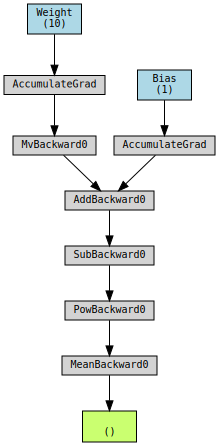

In [17]:
make_dot(loss, params={'Weight': w, 'Bias': b})

Что можно сказать об этом графе вычислений?

- В листьях графа мы не видим тензора `X`, т.к. нам требуется расчёт градиента только по параметрам модели.

- `MvBackward0` соответствует матрично-векторному умножению (отсюда и первые буквы Mv) c матрицей `X`.

- `AddBackward0` соответствует добавлению смещения `b`, остальная часть графа - вычисление MSE.

## Аккумулирование градиентов

Если не предпринимать никаких дополнительных действий, то множественный вызов `backward()` будет не перезаписывать градиенты тензоров, а складывать их с уже существующим значением (сам граф вычислений каждый раз разрушается). Такое поведение может быть, например, нужно, чтобы посчитать градиент по батчу данных, который не влезает в память компьютера целиком, т.к. градиент модели аддитивен по входным данным.

In [18]:
x = torch.randn(3, 3, requires_grad=True)
y = torch.sum(x * x)
y.backward()

x.grad

tensor([[-2.2453, -1.6462,  0.1616],
        [-2.3341,  1.1885, -0.8822],
        [-0.1105, -0.8609,  2.1611]])

In [19]:
z = torch.sum(2 * x)
z.backward()

x.grad # Заметьте, что ко всем значениям прибавилось 2

tensor([[-0.2453,  0.3538,  2.1616],
        [-0.3341,  3.1885,  1.1178],
        [ 1.8895,  1.1391,  4.1611]])

Также подобный подход используется в рекуррентных нейронных сетях, где к одному и тому же тензору весов нейросети происходит несколько обращений во время прямого прохода.

Чтобы считать градиент с нуля, достаточно удалить тензор. В домашней работе вам покажут способ как делать делать это для всех параметров модели одним вызовом.

In [20]:
x.grad = None

## In-place операции над тензорами

По умолчанию, вызов `y = 2 * x` создаст новый тензор, в который скопирует значения x, умноженные на 2. И есть большое желание провести данную операцию на месте, т.е. без аллокации памяти. В nupmy это не имело бы никаких дополнительных последствий, но в pytorch нам надо помнить о графе вычислений, который должен быть без петель, а также может использовать тензоры, рассчитанные при прямом вычислении. В некоторых случаях библиотека может выполнить код и не ругнуться, но описание ситуаций, когда такое сработает, а когда нет, очень сложно, и потому  сами разработчики не рекомендуют использовать in-place операции там, где необходим расчёт градиента.

In-place операции всегда имеют символ `_` на конце.

In [21]:
x = torch.randn(3, 3, requires_grad=True)
y = 2 * x
z = y ** 2  # replace this with c = b + 2 and the autograd error will go away
y.exp_()  # inplace operation!
z.sum().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3, 3]], which is output 0 of ExpBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

Другой распространённый в numpy сценарий - маскированное изменение значений тензора. Это тоже является in-place операцией. В pytorch для этого лучше использовать функцию `torch.where`

In [22]:
x = torch.rand(3,3, requires_grad=True)
x

tensor([[0.6676, 0.1258, 0.2730],
        [0.3598, 0.8222, 0.4697],
        [0.4799, 0.5896, 0.5743]], requires_grad=True)

In [23]:
x[x > 0.5] = 0

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [24]:
torch.where(x > 0.5, 0, x)

tensor([[0.0000, 0.1258, 0.2730],
        [0.3598, 0.0000, 0.4697],
        [0.4799, 0.0000, 0.0000]], grad_fn=<WhereBackward0>)

##  Копирование тензоров

В numpy существует интуитивно понятная функция `copy()`, но в pytorch функции с таким названием нет! Это связано с тем, что тензоры в pytorch привязаны к графу вычислений, который надо также учитывать при копировании.

`.clone()` копирует тензор и сохраняет его привязку к текущему дереву вычислений

In [25]:
x = torch.rand(3, requires_grad=True)
y = x.clone()
y.requires_grad

True

`.detach()` исходя из своего названия, копирует лишь значения элементов тензора, 
отвязывая его от текущего графа вычислений

In [26]:
y = x.detach()
y.requires_grad

False

Продемонстрируем на графе вычислений эти две операции:

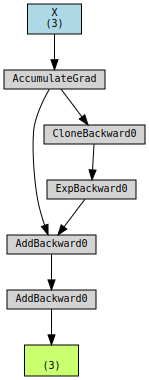

In [27]:
x = nn.Parameter(torch.rand(3))
y = nn.Parameter(torch.rand(3))

x1 = x.clone().exp_() # здесь мы in-place поменяли клон тензора х
z = x + x1 + y.detach()

make_dot(z, params={'X': x, 'Y': y})

Что можно понять из данного графа?

- Видна операция `CloneBackward0`, которая клонирует тензор `x`. Благодаря ей в сумме участвует как исходный тензор, так и его экспонированная версия.

- Во второй сумме мы не видим параметра `y`, потому что он входит в граф вычислений только через `.detach()`, что убирает проход градиентов.

## Менеджеры контекста

Поведением градиента сразу группы тензоров можно управлять с помощью специальных функций, которые вызываются через стандартную семантику питона `with foo():`, где foo - одна из трёх функций ниже:

- Default Mode

    Стандартный режим работы pytorch, в котором управление градиентами происходит через `requires_grad`. Явно его нужно вызывать только внутри других контекстных менеджеров, чтобы временно снова активировать расчёт градиентов (что случается крайне редко) вызовом `torch.enable_grad()`.


- No grad mode

    Данный режим используется когда блока кода нет необходимости вычислять градиенты, что занимает как вычислительные ресурсы, так и дополнительную память. Реализуется вызовом `torch.no_grad()`.


- Inference mode

    Аналогично No grad mode отключает расчёт градиентов, но кроме того проводит дополнительные оптимизации, что делает вычисления внутри блока кода ещё быстрее. Однако, тензоры, созданные в таком блоке будет невозможно использовать совместно с тензорами, для которых расчёт градиента необходим. Реализуется вызовом `torch.inference_mode()`.

In [28]:
x = torch.rand(3, requires_grad=True)

with torch.no_grad():
    y = x + x
    
y.requires_grad

False

In [29]:
@torch.no_grad()
def foo(x):
    return x + 2

In [30]:
y = foo(x)
y.requires_grad

False

## Работа с GPU

pytorch из коробки умеет делать вычисления на gpu через множество различных бекэндов, самый распространённый из которых -  cuda.

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# GPU на Mac также поддерживаются через backend mps
x = torch.tensor([1.,2.,3.], requires_grad=True, device=device)
x

cuda:0


tensor([1., 2., 3.], device='cuda:0', requires_grad=True)

Тензоры можно передавать с устройства на устройство с помощью вызова `.to(device)` или `.cpu()`/`.cuda()`. Последним пользоваться не рекомендуется, т.к. на устройстве может не быть cuda. 

Конвертация в numpy работает ТОЛЬКО для тензоров, находящихся на cpu и без градиентов!

In [32]:
x.numpy() # не перевели на cpu

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [33]:
x.cpu().numpy() # не убрали градиент

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [34]:
x.detach().cpu().numpy() # вот теперь хорошо

array([1., 2., 3.], dtype=float32)

Нельзя использовать в одной операции тензоры, находящиеся на разных устройствах. По умолчанию тензоры создаются на cpu. Однако, часто встречаются ситуации, когда необходимо добавить в граф вычислений созданные на месте тензоры. Если явно не указать устройство для этих тензоров, то случится ошибка:

In [35]:
y = torch.rand(3)
x + y

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [36]:
y = torch.rand(3, device=x.device)
x + y

tensor([1.6965, 2.6396, 3.7496], device='cuda:0', grad_fn=<AddBackward0>)

## `.item`

Часто при подсчёте метрик возникают тензоры из одного элемента/скаляры, которые могут находится на GPU или быть частью графа вычислений.

Сохранение таких тензоров в массив приведёт к утечке памяти. Чтобы этого избежать существует возможность трансформирования таких тензоров в Python скаляр:

In [ ]:
x = torch.randn(10, requires_grad=True)
loss = torch.mean(x, dim=0, keepdim=True)
loss, loss.item()

## Дополнительные библиотеки и функции

При прохождении данного курса вам могут оказаться полезны следующие функции:

- Сконкатенировать набор тензоров вдоль заданной размерности [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)

- Соединить тензоры одинаковой формы вдоль новой размерности [torch.stack]()
- Добавить/убрать новую "единичную" размерность в тензор [torch.unsqueeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html)/[torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html)
- Разбить тензор на заданное число блоков [torch.chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html)
- Переставить между собой __две__ размерности [torch.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html)
- Переставить местами __все__ размерности [torch.permute](https://pytorch.org/docs/stable/generated/torch.permute.html)
- Повторить тензор [torch.tile](https://pytorch.org/docs/stable/generated/torch.tile.html)/[torch.repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html)
- Найти максимальный элемент (возвращает И положение, И значение)[torch.max](https://pytorch.org/docs/stable/generated/torch.max.html)
- Поэлементный максимум между __двумя__ тензорами[torch.maximum](https://pytorch.org/docs/stable/generated/torch.maximum.html)
- "Выпрямить" тензор, объединив все размерности в одну [torch.ravel](https://pytorch.org/docs/stable/generated/torch.ravel.html)
- Объединить только заданные размерности [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)
- Вернуть k наибольших элементов [torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html)

Кроме того, Pytorch включает в себя набор дополнительных модулей, которые аналогичны соответствующим модулям в numpy с той лишь разницей, что здесь через все функции можно автоматически посчитать градиент.

- [torch.linalg](https://pytorch.org/docs/stable/linalg.html) матричные операции, разложения и СЛАУ

- [torch.special](https://pytorch.org/docs/stable/special.html) функция ошибок и другие специальные функции, доступна с версии 1.9.0